C:\Users\lixue\AppData\Local\Temp\ipykernel_25368\2338950829.py:58: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = stats.norm.cdf((np.log(S/K)+(r + 0.5 *sigma**2)*T) / (sigma * np.sqrt(T)))




+--------------+-----------------------+
| Interval:21  |         Value         |
+--------------+-----------------------+
| Mean of N=21 | -0.008051165496447295 |
| Std of N=21  |   0.4253536038223828  |
+--------------+-----------------------+


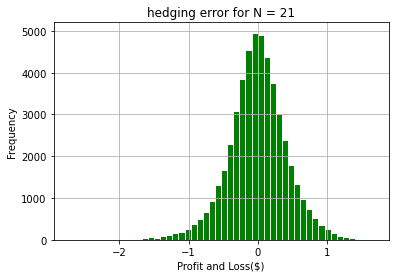



+--------------+-----------------------+
| Interval:84  |         Value         |
+--------------+-----------------------+
| Mean of N=84 | -0.009271901805560642 |
| Std of N=84  |  0.21802361713955626  |
+--------------+-----------------------+


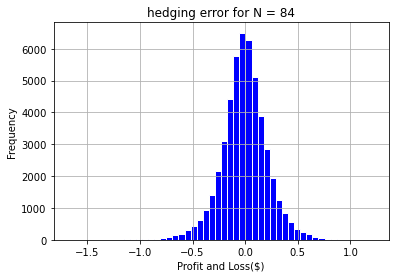

In [9]:
# -*- coding: utf-8 -*-
"""
Created on Sun Nov 13 09:26:42 2022

@author: lixuebin
"""

import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import warnings
warnings.simplefilter("ignore", UserWarning)
import pandas as pd
from prettytable import PrettyTable


"""
Variables:
"""
S0 = 100
sigma = 0.2
r = 0.05
T = 1/12
K = S0
steps_N21 = 21
steps_N84 = 84
paths = 50000

"""
Part IV - Dynamic Hedging:
    
Black-Scholes Call Option Pricing Formula
Ct = φtSt − ψtBt
stock minus bond
"""

def Ct(S0, K, r, sigma, T):
    d1 = (np.log(S0/K) + (r + 0.5* sigma**2) *T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S0*stats.norm.cdf(d1) - K*np.exp(-r*T)*stats.norm.cdf(d2)



"""
this is the standard get ST = S0 e^(rt - 1/2 * (sigma)^2 + sigmaW)
This will allow us to get the stock price at S0.
"""

def ST(S0, r, t, sigma, W):
    return S0*np.exp((r*t-0.5*sigma**2*t)+sigma*W)


"""
φt
"""

def tSt(S, K, r, sigma, T):   
    d1 = stats.norm.cdf((np.log(S/K)+(r + 0.5 *sigma**2)*T) / (sigma * np.sqrt(T)))
    return d1



# Formula to simulate Brownian Motion Paths
def simulate_Brownian_Motion(paths, steps, T):

    delta = T/steps
    np.random.seed(1)
    #loop from 0 to 0.08333. in between has 21 values or 84 values.
    t = np.linspace(0, T, steps+1)
    """
    #X = np.c_[np.zeros((50,000, 1)), np.random.randn(50,000, 21)]
    #This code is to always assign 0 as first column and 
    add the rest 21 random values
    This will create a total of 50,000 rows with 22 values or 85 values.
    """
    X = np.c_[np.zeros((paths, 1)),
              np.random.randn(paths, steps)]
    #sqrt(1/12 divide by 21)
    #delta is the hedging frequency, it is 1 month hedge 21 times or 1month hedge 84 times
    return t, np.cumsum(np.sqrt(delta) * X, axis=1)


"""
X21 is adding all 1 month / 21 * 50,000 x 22 values
T_84 is adding all 1 month / 84 * 50,000 x 22 values
T_84 will have smaller std and variance
"""
T_21, X_21 = simulate_Brownian_Motion(paths, steps_N21, T) # Simulate Brownian Paths with 21 steps
T_84, X_84 = simulate_Brownian_Motion(paths, steps_N84, T) # Simulate Brownian Paths with 84 steps

#T_21 = t 
#X_21 = brownian motion W

#This is the stock price for all time steps.
ST_21 = ST(S0, r, T_21, sigma, X_21)
ST_84 = ST(S0, r, T_84, sigma, X_84)

"""

Find the call option price bought
find the stock price sold
find the pnl for each time step 
use stock price at T-time step to minus stock price at T-1 time step and calculate pnl
Sum of all pnl + call option price - payoff.

"""

error_hedging = []
Ct_boughtAtTimeZero = Ct(S0, K, r, sigma, T)

def hedging_error_pnl(stock_price,T_84or21,N):
    error_hedging = []
    for rows in stock_price:
        pnl = []
        previous_stock_price = 0
        for stepsToExpiry in range(0,len(rows)):
            Stock_price_current= tSt(rows[stepsToExpiry],K,r,sigma,(T-T_84or21[stepsToExpiry]))
            if stepsToExpiry == 0:
                pnl.append((-Stock_price_current)*rows[stepsToExpiry]*np.exp(r*(T-T_84or21[stepsToExpiry])))
            else:
               pnl.append((-Stock_price_current+previous_stock_price) * 
                          rows[stepsToExpiry]*np.exp(r*(T-T_84or21[stepsToExpiry])))              
                
            previous_stock_price = Stock_price_current
        if rows[N] < 100:
            error_hedging.append(np.sum(pnl) + Ct_boughtAtTimeZero)
        else:
            error_hedging.append(np.sum(pnl) + K + Ct_boughtAtTimeZero)    
    
    print("")
    print("")
    
    if(N==21):
        color_hist = "green"
    else:
        color_hist = "blue"
    
    t = PrettyTable(['Interval:' +str(N) + "", 'Value'])
    t.add_row(['Mean of N=' +str(N) + "", np.mean(error_hedging)])
    t.add_row(['Std of N='+str(N) + "", np.std(error_hedging)])
    print(t)
    
    
    plt.hist(error_hedging, edgecolor='white', bins=50, 
              align='mid', color = color_hist)
    plt.ylabel("Frequency")
    plt.xlabel("Profit and Loss($)")
    plt.title("hedging error for N = %i" %N )
    plt.grid()
    plt.savefig('error.jpg', format='jpg', dpi=1000)
    plt.show()


hedging_error_pnl(ST_21,T_21,steps_N21)
hedging_error_pnl(ST_84,T_84,steps_N84)


